'spectrogram2.png'

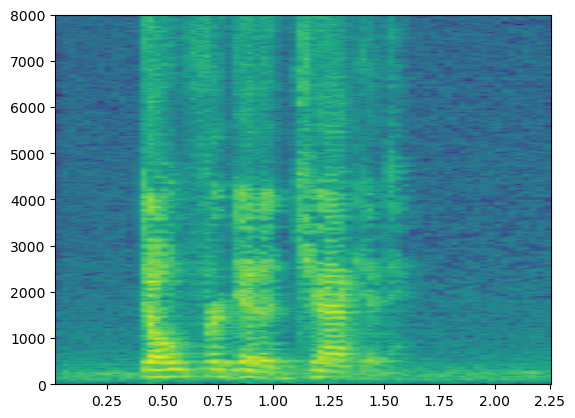

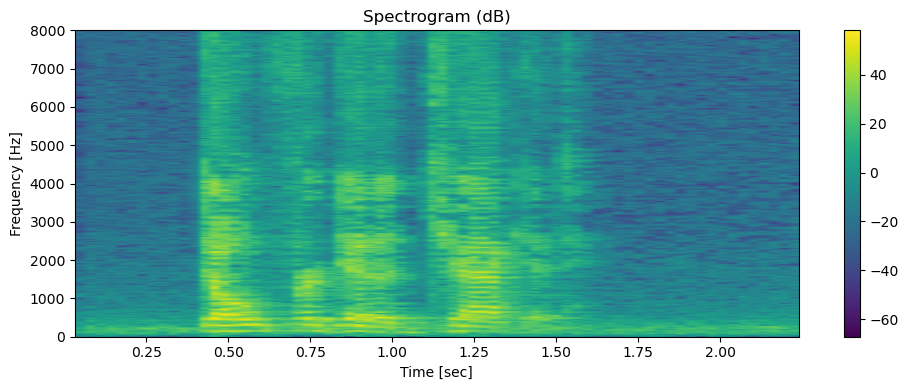

In [1]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
file_path = '1001_DFA_ANG_XX.wav'
sampling_rate, data = wavfile.read(file_path)

# Generate the spectrogram
Pxx, freqs, bins, im = plt.specgram(data, NFFT=1024, Fs=sampling_rate, noverlap=512)

# Convert to dB scale
Pxx_dB = 10 * np.log10(Pxx)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(Pxx_dB, aspect='auto', origin='lower',
           extent=[bins.min(), bins.max(), freqs.min(), freqs.max()])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram (dB)')
plt.tight_layout()

# Save the spectrogram image
spectrogram_path = 'spectrogram2.png'
plt.savefig(spectrogram_path)

spectrogram_path

In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the previously saved spectrogram image
spectrogram_image_path = 'spectrogram2.png'
spectrogram_image = Image.open(spectrogram_image_path)

# Define a transform to convert the image to tensor and resize to the input size expected by the model
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128 (or whatever your model expects)
    transforms.Grayscale(),  # Convert the image to grayscale if your model expects one channel input
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Apply the transform to the spectrogram image
spectrogram_tensor = transform(spectrogram_image)

# Add a batch dimension (model expects batch_size x channels x height x width)
spectrogram_tensor = spectrogram_tensor.unsqueeze(0)

spectrogram_tensor.shape

torch.Size([1, 1, 128, 128])

In [7]:
import torch
# Asegúrate de que septr.py y septr_block.py estén en tu directorio de trabajo o ajusta las rutas de importación según sea necesario.
from septr import SeparableTr

# Instancia el modelo SepTr con la configuración deseada
model = SeparableTr(
    channels=1,  # Ajusta según tu espectrograma
    input_size=(128, 128),  # Ajusta según el tamaño de entrada esperado por el modelo
    num_classes=6,  # Ajusta según el número de clases que tu modelo debe predecir
    # Otros parámetros según sea necesario
)

# Asegúrate de cargar los pesos del modelo si tienes un archivo de estado guardado
# model.load_state_dict(torch.load('path_to_your_model_weights.pth'))
model.train()
# Evaluar el modelo en modo de inferencia
model.eval()

# Suponiendo que 'spectrogram_tensor' es tu tensor de entrada preparado anteriormente
with torch.no_grad():
    predictions = model(spectrogram_tensor)

# Procesa las 'predictions' según sea necesario para tu aplicación
# Por ejemplo, obtener la clase más probable
predicted_class = predictions.argmax(dim=1)
print(f"Clase predicha: {predicted_class.item()}")

Clase predicha: 4


In [4]:
model

SeparableTr(
  (transformer): ModuleList(
    (0): SepTrBlock(
      (avg_pool): Identity()
      (upsample): Identity()
      (projection): Linear(in_features=1, out_features=256, bias=True)
      (reconstruction): Identity()
      (rearrange_patches_h): Rearrange('b c h w -> b w h c')
      (rearrange_patches_w): Rearrange('b c h w -> b h w c')
      (rearrange_in_tr): Rearrange('b c h w -> (b c) h w')
      (rearrange_out_tr_h): Rearrange('(b c) h w -> b w h c', c=128)
      (rearrange_out_tr_w): Rearrange('(b c) h w -> b w c h', c=128)
      (transformer_w): Transformer(
        (layers): ModuleList(
          (0): ModuleList(
            (0): PreNorm(
              (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
              (fn): Attention(
                (attend): Softmax(dim=-1)
                (to_qkv): Linear(in_features=256, out_features=3840, bias=False)
                (to_out): Sequential(
                  (0): Linear(in_features=1280, out_features=256, b